# Estimation of VMT values

## 1. Packages

In [1]:
# IMPORT LIBRARIES
# !pip install pmdarima ## Uncomment this line if ModuleNotFoundError is issued for pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-darkgrid')
%matplotlib inline


from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from statsmodels.tsa.seasonal import seasonal_decompose      
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima                              # for determining SARIMA orders

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tools.eval_measures import rmse

from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
Importing plotly failed. Interactive plots will not work.


## 2. Data

### 2.1. Data description: Vehicle miles traveled (VMT) 
VMT plays important role in transportation planning. It measures the amount of travel for all vehicles in a geographic region over a given period of time. It is calculated as the sum of the number of miles traveled by each vehicle.

This dataset is available at https://fred.stlouisfed.org/series/TRFVOLUSM227NFWA

In [2]:
# Loading the data
df = pd.read_csv('VMT.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'
df.rename(columns={"TRFVOLUSM227NFWA":"vmt"}, inplace = True)
df.head()

,vmt
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0


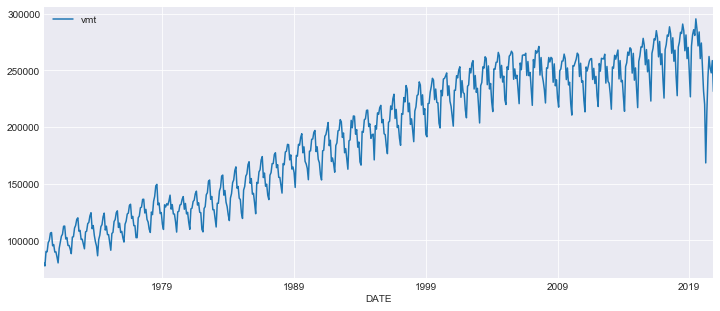

In [3]:
# Visualize the data
df['vmt'].plot(figsize = (12,5), legend=True)

### 2.3. Check Stationarity of the time series

In [4]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity_with_adf_test(series,title=''):
    """
    Returns True if data is stationary else False 
    using Augmented Dickey-Fuller Test.
    """
    print(f'Augmented Dickey-Fuller Test')
    ## AIC = 2k-2log(L), 
    ## k: # of params, L: max. value of the likelihood function
    result = adfuller(series.dropna(),autolag='AIC')     
    if result[1] <= 0.05:
        print("Strong evidence against H_0.")
        print("Data is stationary!")
        return True
    else:
        print("Weak evidence against H_0.")
        print("Data is non-stationary!")
        return False
    
ts_is_stationary = check_stationarity_with_adf_test(df['vmt'],title='')

Augmented Dickey-Fuller Test
Weak evidence against H_0.
Data is non-stationary!


### 2.2. Seasonal Decomposition of the time series df['vmt']

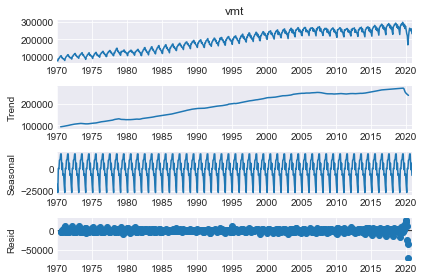

In [5]:
# Seasonal-Trend-Residual Decomposition: using additive model
result = seasonal_decompose(df['vmt'], model='add')  # model='additive'
result.plot();

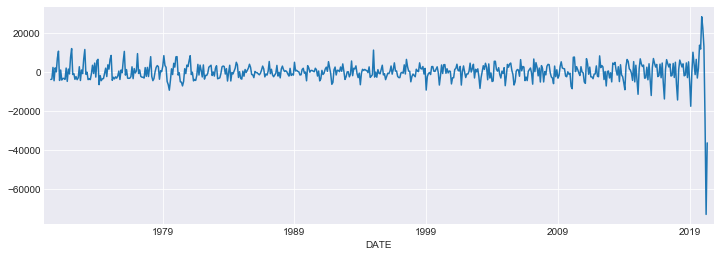

In [6]:
result.resid.plot(figsize=(12,4))

### 2.3. Train-test split

In [7]:
## Test set consists of the data last 3 years.
len_df = len(df)
len_train = len_df - 36 
train = df.iloc[:len_train]
test = df.iloc[len_train:] 

### 2.4. Feature scaling

In [8]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## 3. Models


### 3.1. LSTM

Epoch 1/20
551/551 [==============================] - 10s 18ms/step - loss: 0.0133
Epoch 2/20
551/551 [==============================] - 7s 12ms/step - loss: 0.0062
Epoch 3/20
551/551 [==============================] - 7s 12ms/step - loss: 0.0057
Epoch 4/20
551/551 [==============================] - 7s 13ms/step - loss: 0.0049
Epoch 5/20
551/551 [==============================] - 7s 13ms/step - loss: 0.0039
Epoch 6/20
551/551 [==============================] - 7s 12ms/step - loss: 0.0027
Epoch 7/20
551/551 [==============================] - 7s 13ms/step - loss: 0.0023
Epoch 8/20
551/551 [==============================] - 7s 12ms/step - loss: 0.0026
Epoch 9/20
551/551 [==============================] - 7s 13ms/step - loss: 0.0020
Epoch 10/20
551/551 [==============================] - 7s 13ms/step - loss: 0.0022
Epoch 11/20
551/551 [==============================] - 7s 13ms/step - loss: 0.0020
Epoch 12/20
551/551 [==============================] - 7s 14ms/step - loss: 0.0023
Epoch 13/20


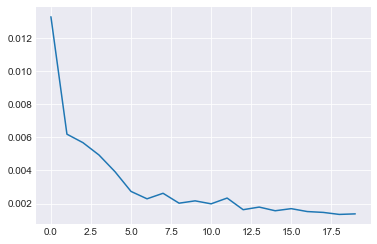

In [9]:
n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

model = Sequential()
model.add(LSTM(120, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=20)

loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

### 3.2. SARIMA
Run pmdarima.auto_arima to obtain recommended orders

In [10]:
model_recommended = auto_arima(scaled_train, start_p = 0, start_q = 0, max_p = 3, max_q = 3, seasonal=True, trace = True, m=12)
model_sarima = SARIMAX(scaled_train,order=model_recommended.order,seasonal_order=model_recommended.seasonal_order)
result_sarima = model_sarima.fit()
print('\nSummary of the recommended parameters:')
model_recommended.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-3117.783, Time=1.99 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-2978.484, Time=0.46 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3143.335, Time=1.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-3259.066, Time=1.44 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-3135.935, Time=0.25 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-3270.586, Time=3.68 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-3190.230, Time=1.73 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=-3275.093, Time=6.36 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-3234.944, Time=4.24 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=-3272.665, Time=9.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-3274.767, Time=10.31 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=-3128.054, Time=7.21 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=-3274.859, Time=8.39 sec
 ARIMA(0,1,2)(2,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  575
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                1642.546
Date:                            Mon, 22 Feb 2021   AIC                          -3275.093
Time:                                    20:30:50   BIC                          -3253.435
Sample:                                         0   HQIC                         -3266.637
                                            - 575                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5950      0.027    -22.215      0.000      -0.647      -0.542
ar.S.L12       0.1549      0.084      1.852      0.064      -0.009       0.319
ar.S.L24      -0.1105      0.059     -1.863      0.063      -0.227       0.006
ma.S.L12      -0.6631      0.080     -8.274      0.000      -0.820      -0.506
sigma2         0.0002   7.75e-06     21.886      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       87.82   Jarque-Bera (JB):               108.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                            -0.24
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3.3. FBProphet

In [11]:
df_pr = df.copy(deep = True)
df_pr['Date'] = df_pr.index
df_pr.columns = ['y', 'ds']
df_pr.head()

,y,ds
DATE,,
1970-01-01,80173.0,1970-01-01
1970-02-01,77442.0,1970-02-01
1970-03-01,90223.0,1970-03-01
1970-04-01,89956.0,1970-04-01
1970-05-01,97972.0,1970-05-01


In [12]:
train_fb = df_pr.iloc[:len_train]
test_fb = df_pr.iloc[len_train:]
model_prophet = Prophet()
model_prophet.fit(train_fb)
future = model_prophet.make_future_dataframe(periods=len(test),freq='MS')
predictions_prophet = model_prophet.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## 4. Test models
Compare the performance of the models on the test data

In [13]:
def predict_lstm(scaled_train, n_input, n_features, len_test):
    scaled_test_preds = []
    predictions_lstm = []

    first_eval_batch = scaled_train[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    for i in range(len_test):

        current_pred = model.predict(current_batch)[0]
        scaled_test_preds.append(current_pred) 
        
        # update batch: drop first value, add prediction
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

    
    predictions_lstm = scaler.inverse_transform(scaled_test_preds)
    
    return predictions_lstm

predictions_lstm = predict_lstm(scaled_train, n_input, n_features, len(test))
test['Predictions-LSTM'] = predictions_lstm

start=len(scaled_train)
end=len(scaled_train)+len(test)-1
scaled_test_preds = result_sarima.predict(start=start, end=end, dynamic=False, typ='levels')
predictions_sarima = scaler.inverse_transform(scaled_test_preds.reshape(-1,1))

test['Predictions-SARIMA'] = predictions_sarima

predictions_prophet.index = predictions_prophet['ds']
test['Predictions-Prophet'] = predictions_prophet['yhat'][-len(test):]

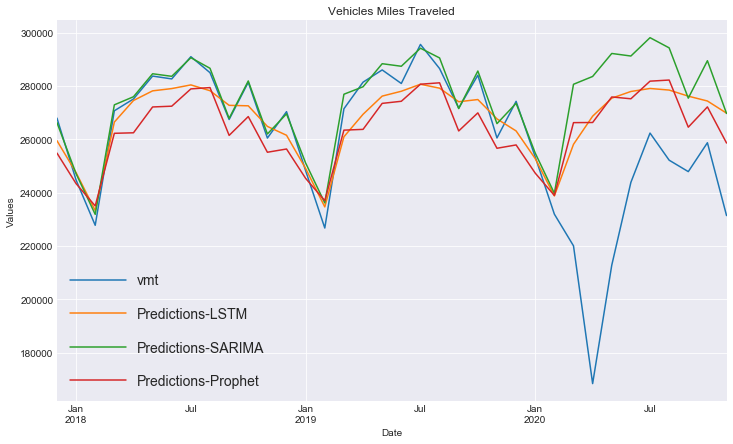

In [14]:
## Visualize the performance of models
title = 'Vehicles Miles Traveled'
ylabel='Values'
xlabel='Date'
ax = test.plot(figsize=(12,7), legend = True, title = title)
ax.set(xlabel=xlabel, ylabel=ylabel);
ax.autoscale(axis='x',tight=True)

ax.legend(loc='lower left', labelspacing=1.4, handlelength=4, fontsize=14)


## 5. Compare Models

In [15]:
df_rmse = pd.DataFrame([0,0,0], index=test.columns[1:], columns = ["rmse"])
df_rmse
j=0
for i in test.columns[1:]:
    df_rmse["rmse"][j] = rmse(test["vmt"], test[i])
    j +=1
    
df_rmse

,rmse
Predictions-LSTM,24508
Predictions-SARIMA,29830
Predictions-Prophet,24747
